# LDA Hyperparameters tuning (subsample 50K of training datasets)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# load back
df_train_load = pd.read_pickle('train_clean_1_token.pkl')
df_train_load.shape, display(df_train_load.head(3))

In [3]:
df_train_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067317 entries, 0 to 2067316
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   year                   int64  
 2   month                  float64
 3   day                    int64  
 4   publication            object 
 5   title_article_cleaned  object 
 6   tokens                 object 
dtypes: float64(1), int64(2), object(4)
memory usage: 110.4+ MB


In [ ]:
df_train_load = df_train_load.sample(50000)

In [5]:
df_train_load.head(5)

,date,year,month,day,publication,title_article_cleaned,tokens
979171,2019-06-12 00:00:00,2019,6.000,12,Refinery 29,tessa thompson chri hemsworth real life friend...,"[tessa, thompson, chri, hemsworth, real, life,..."
1170862,2019-08-23 17:00:00,2019,8.000,23,People,reason everyth know season reason season final...,"[reason, everyth, know, season, reason, season..."
1971867,2020-02-11 00:00:00,2020,2.000,11,The Hill,klobuchar democrat nh villag cast ballot thehi...,"[klobuchar, democrat, nh, villag, cast, ballot..."
166673,2016-10-20 00:00:00,2016,10.000,20,Mashable,pint craft beer come energyeffici greenhous in...,"[pint, craft, beer, come, energyeffici, greenh..."
1022538,2019-05-15 15:54:00,2019,5.000,15,People,ky toddler vanish home sunday find aliv updat ...,"[ky, toddler, vanish, home, sunday, find, aliv..."


In [6]:
df_train_load.to_csv('sub_sample/train_sample.csv', index=False)

In [2]:
df_train_load = pd.read_csv('sub_sample/train_sample.csv')

In [4]:
df_train_load.shape, display(df_train_load.head(5))

,date,year,month,day,publication,title_article_cleaned,tokens
0,2019-06-12 00:00:00,2019,6.000,12,Refinery 29,tessa thompson chri hemsworth real life friend...,"['tessa', 'thompson', 'chri', 'hemsworth', 're..."
1,2019-08-23 17:00:00,2019,8.000,23,People,reason everyth know season reason season final...,"['reason', 'everyth', 'know', 'season', 'reaso..."
2,2020-02-11 00:00:00,2020,2.000,11,The Hill,klobuchar democrat nh villag cast ballot thehi...,"['klobuchar', 'democrat', 'nh', 'villag', 'cas..."
3,2016-10-20 00:00:00,2016,10.000,20,Mashable,pint craft beer come energyeffici greenhous in...,"['pint', 'craft', 'beer', 'come', 'energyeffic..."
4,2019-05-15 15:54:00,2019,5.000,15,People,ky toddler vanish home sunday find aliv updat ...,"['ky', 'toddler', 'vanish', 'home', 'sunday', ..."


((50000, 7), None)

# Preparing to do n-gram

In [5]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

In [6]:
token_words = list(df_train_load['tokens'])

In [7]:
token_words[:1]

["['tessa', 'thompson', 'chri', 'hemsworth', 'real', 'life', 'friendship', 'hollywood', 'mani', 'great', 'onscreen', 'duo', 'rare', 'translat', 'offscreen', 'friendship', 'rarer', 'friendship', 'actual', 'jump', 'franchis', 'anoth', 'exactli', 'chri', 'hemsworth', 'tessa', 'thompson', 'pair', 'thor', 'ragnarok', 'later', 'reunit', 'aveng', 'endgam', 'star', 'anoth', 'movi', 'togeth', 'year', 'men', 'black', 'intern', 'honestli', 'deserv', 'second', 'dose', 'togeth', 'whatev', 'let', 'men', 'black', 'intern', 'hemsworth', 'thompson', 'play', 'cowork', 'accur', 'friend', 'work', 'start', 'jet', 'set', 'adventur', 'globe', 'tri', 'stop', 'els', 'alien', 'invas', 'ye', 'clearli', 'mo', 'come', 'work', 'togeth', 'movi', 'mean', 'constant', 'stream', 'behindthescen', 'post', 'silli', 'interview', 'bud', 'ship', 'hemsworth', 'thompson', 'friendship', 'begin', 'discov', 'look', 'fall', 'hempson', 'hole', 'coin', 'best', 'social', 'media', 'post', 'stan', 'beauti', 'friendship']"]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# bigram

In [11]:
# started at ~3:55pm at April 17th!! (less than 1 minutes)
token_words = df_train_load['tokens']
# Adding vocabs
# build the bigram models ...
bigram = gensim.models.Phrases(token_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# min_count ignore all words and bigrams with total collected count lower than 5 (default)
# threshold represents a threshold for forming the phrases (default is 10)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [15]:
bigram_mod.save('sub_sample/bigram_model')

In [12]:
# started at ~3:56pm, done at 4:06?? may be earlier
# Form Bigrams
token_words_bigrams = make_bigrams(token_words)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
# Do lemmatization keeping only noun, adj, vb, adv
token_words_bigrams_lemm = lemmatization(token_words_bigrams, 
                                        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
token_words_bigrams_lemm[:10]

[['real',
  'life',
  'friendship',
  'hollywood',
  'great',
  'onscreen',
  'duo',
  'rare',
  'translat',
  'offscreen',
  'friendship',
  'rarer',
  'friendship',
  'actual',
  'jump',
  'anoth',
  'tessa_thompson',
  'pair',
  'thor_ragnarok',
  'later',
  'reunit',
  'star',
  'anoth',
  'togeth',
  'year',
  'man',
  'black',
  'dose',
  'whatev',
  'let',
  'man',
  'black',
  'intern',
  'accur',
  'friend',
  'work',
  'start',
  'jet',
  'set',
  'adventur',
  'stop',
  'el',
  'alien',
  'clearli',
  'come',
  'work',
  'togeth',
  'mean',
  'constant',
  'stream',
  'behindthescen',
  'post',
  'interview',
  'bud',
  'ship',
  'friendship',
  'begin',
  'fall',
  'hole',
  'coin',
  'good',
  'post',
  'friendship'],
 ['reason',
  'everyth',
  'know',
  'season',
  'reason',
  'season',
  'final',
  'new',
  'season',
  'provoc',
  'hit',
  'premier',
  'motion',
  'anoth',
  'new',
  'wait',
  'solv',
  'find',
  'student',
  'high',
  'school',
  'cop',
  'let',
  'look

In [18]:
import pickle

with open("sub_sample/bigram_token", "wb") as fp:   #Pickling
    pickle.dump(token_words_bigrams_lemm, fp)

# trigram 

In [19]:
# started at 4:07 ....4:14
# build trigram models .
trigram = gensim.models.Phrases(bigram[token_words], threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram) 

In [20]:
trigram_mod.save('sub_sample/trigram_model')

In [21]:
# started at 4:14 and end at most 4:44
# Form Trigrams
token_words_trigrams = make_trigrams(token_words)
token_words_trigrams_lemm = lemmatization(token_words_trigrams, 
                                        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [22]:
token_words_trigrams_lemm[:10]

[['real',
  'life',
  'friendship',
  'hollywood',
  'great',
  'onscreen',
  'duo',
  'rare',
  'translat',
  'offscreen',
  'friendship',
  'rarer',
  'friendship',
  'actual',
  'jump',
  'anoth',
  'tessa_thompson',
  'pair',
  'thor_ragnarok',
  'later',
  'reunit',
  'star',
  'anoth',
  'togeth',
  'year',
  'man',
  'black',
  'dose',
  'whatev',
  'let',
  'man',
  'black',
  'intern',
  'accur',
  'friend',
  'work',
  'start',
  'jet',
  'set',
  'adventur',
  'stop',
  'el',
  'alien',
  'clearli',
  'come',
  'work',
  'togeth',
  'mean',
  'constant',
  'stream',
  'behindthescen',
  'post',
  'interview',
  'bud',
  'ship',
  'friendship',
  'begin',
  'fall',
  'hole',
  'coin',
  'good',
  'post',
  'friendship'],
 ['reason',
  'everyth',
  'know',
  'season',
  'reason',
  'season',
  'final',
  'new',
  'season',
  'provoc',
  'hit',
  'premier',
  'motion',
  'anoth',
  'new',
  'wait',
  'solv',
  'find',
  'student',
  'liberti',
  'cop',
  'let',
  'look',
  'thi

In [23]:
with open("sub_sample/trigram_token", "wb") as fp:   #Pickling
    pickle.dump(token_words_trigrams_lemm, fp)

In [24]:
# create a dictionary containing the number of times a word appears in the training dataset
id2word = gensim.corpora.Dictionary(token_words_trigrams_lemm) # change from trigrams to bigrams

In [25]:
print(type(id2word))

count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

<class 'gensim.corpora.dictionary.Dictionary'>
0 accur
1 actual
2 adventur
3 alien
4 anoth
5 begin
6 behindthescen
7 black
8 bud
9 clearli
10 coin


In [26]:
# filter out tokens that appear in < 100 documents or more than 0.5 documents (fraction of total corpus size), or
# after the above two steps, keep only the first 100,000 most frequent tokens????
# id2word.filter_extremes(no_below=100, no_above=0.5, keep_n=20000) 
# id2word.filter_extremes(no_below=100, no_above=0.5, keep_n=20000) ########## changes here ...
id2word.filter_extremes(no_below=20, no_above=0.6)
'''
We removed all terms that occur fewer than 20 times across all documents and all terms that occur in more 
than 60% of all the documents. We are interested in finding different themes and topics and not recurring themes.

'''
# filter out tokens that appears more than 50% of the document

In [27]:
# after filter, create corpus
texts = token_words_trigrams_lemm  #token_words_trigrams_lemm

# create term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
DICT_PATH="sub_sample/id2word"
CORPUS_PATH="sub_sample/corpus"
id2word.save(DICT_PATH)
corpora.MmCorpus.serialize(CORPUS_PATH, corpus)

# Load everything back

In [8]:
# load everything back
import pickle

with open("sub_sample/trigram_token", "rb") as fp:   # Unpickling
    token_words_trigrams_lemm = pickle.load(fp)
    
DICT_PATH="sub_sample/id2word"
CORPUS_PATH="sub_sample/corpus"
    
id2word = corpora.Dictionary.load(DICT_PATH)
corpus = corpora.MmCorpus(CORPUS_PATH)

# LDA

In [9]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

/Users/djoko/opt/anaconda3/lib/python3.9/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/Users/djoko/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [10]:
# starting around 4:54pm end 5:39pm
num_topics = [10,15,20,25,30]
num_keywords = 15 #??
LDA_models = {}
LDA_topics = {}
coherence_values = []

def coherence_computation(model):
    coherence = CoherenceModel(
        model = model, 
        texts = token_words_trigrams_lemm,
        dictionary = id2word, 
        coherence='c_v' # Coherence score??
        )
    return coherence.get_coherence()

for t in num_topics:
    print(f"Number of topics= {t}")
    LDA_models[t] = gensim.models.LdaMulticore(corpus=corpus, # multicore uses all CPUs
                   id2word=id2word,
                    num_topics=t,
                    chunksize = 100, 
                    passes=20, 
                    random_state=42)
    # get coherence score
    coherence = coherence_computation(LDA_models[t])
    coherence_values.append(coherence)
    shown_topics = LDA_models[t].show_topics(num_topics=t, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[t] = [[word[0] for word in topic[1]] for topic in shown_topics]

Number of topics= 10
Number of topics= 15
Number of topics= 20
Number of topics= 25
Number of topics= 30


In [11]:
LDA_models

{10: <gensim.models.ldamulticore.LdaMulticore at 0x7fe18097a1f0>,
 15: <gensim.models.ldamulticore.LdaMulticore at 0x7fe1809aff40>,
 20: <gensim.models.ldamulticore.LdaMulticore at 0x7fe1809a8f70>,
 25: <gensim.models.ldamulticore.LdaMulticore at 0x7fe179321f70>,
 30: <gensim.models.ldamulticore.LdaMulticore at 0x7fe17435df70>}

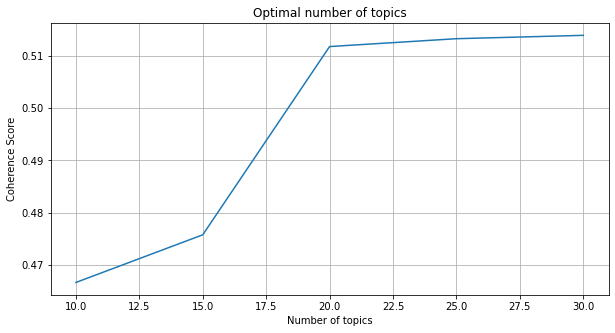

In [12]:
fig = plt.figure(figsize=(10,5))
plt.title('Optimal number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.plot(num_topics, coherence_values)

In [13]:
# Print the coherence scores
#limit=40; start=5; step=6;
#x = range(start, limit, step)
x = num_topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4666
Num Topics = 15  has Coherence Value of 0.4758
Num Topics = 20  has Coherence Value of 0.5118
Num Topics = 25  has Coherence Value of 0.5133
Num Topics = 30  has Coherence Value of 0.5139


In [14]:
# decide which one is the best
from pprint import pprint

pprint(LDA_models[20].print_topics())
#doc_lda = lda_model[corpus]

[(0,
  '0.018*"report" + 0.016*"investig" + 0.015*"court" + 0.014*"case" + '
  '0.011*"feder" + 0.010*"rule" + 0.010*"law" + 0.010*"inform" + 0.009*"legal" '
  '+ 0.009*"claim"'),
 (1,
  '0.033*"car" + 0.018*"flight" + 0.014*"air" + 0.014*"space" + 0.014*"test" + '
  '0.014*"system" + 0.011*"plan" + 0.011*"driver" + 0.011*"vehicl" + '
  '0.010*"use"'),
 (2,
  '0.015*"new" + 0.014*"compani" + 0.014*"develop" + 0.014*"busi" + '
  '0.012*"year" + 0.011*"technolog" + 0.010*"work" + 0.010*"market" + '
  '0.009*"industri" + 0.008*"build"'),
 (3,
  '0.040*"woman" + 0.012*"man" + 0.012*"black" + 0.012*"work" + 0.011*"art" + '
  '0.008*"artist" + 0.007*"write" + 0.007*"book" + 0.006*"find" + '
  '0.006*"young"'),
 (4,
  '0.026*"tax" + 0.021*"pay" + 0.016*"year" + 0.015*"money" + 0.015*"plan" + '
  '0.014*"state" + 0.013*"spend" + 0.012*"bill" + 0.011*"feder" + '
  '0.011*"worker"'),
 (5,
  '0.023*"food" + 0.017*"good" + 0.012*"store" + 0.012*"product" + 0.012*"eat" '
  '+ 0.011*"amazon" + 0.010

# Evaluate performance

In [15]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [16]:
# use the above to derive the mean stability across topics by considering the next topics
LDA_stability = {}

for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [17]:
len(LDA_stability)

4

In [18]:
mean_stabilities

[0.08487931760045238,
 0.06469677772929823,
 0.05236413416487962,
 0.04732680935886593]

In [19]:
# ----------- need to rerun!! ************************** 6 minutes
coherences = [CoherenceModel(model=LDA_models[i], texts=token_words_trigrams_lemm,
        dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [20]:
coherences

[0.4666400715886251,
 0.4757612457997716,
 0.5117980924612869,
 0.5133021259356233]

In [23]:
#coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] 
        # limit topic numbers to the number of keywords
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics)-1)]
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] 
        # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

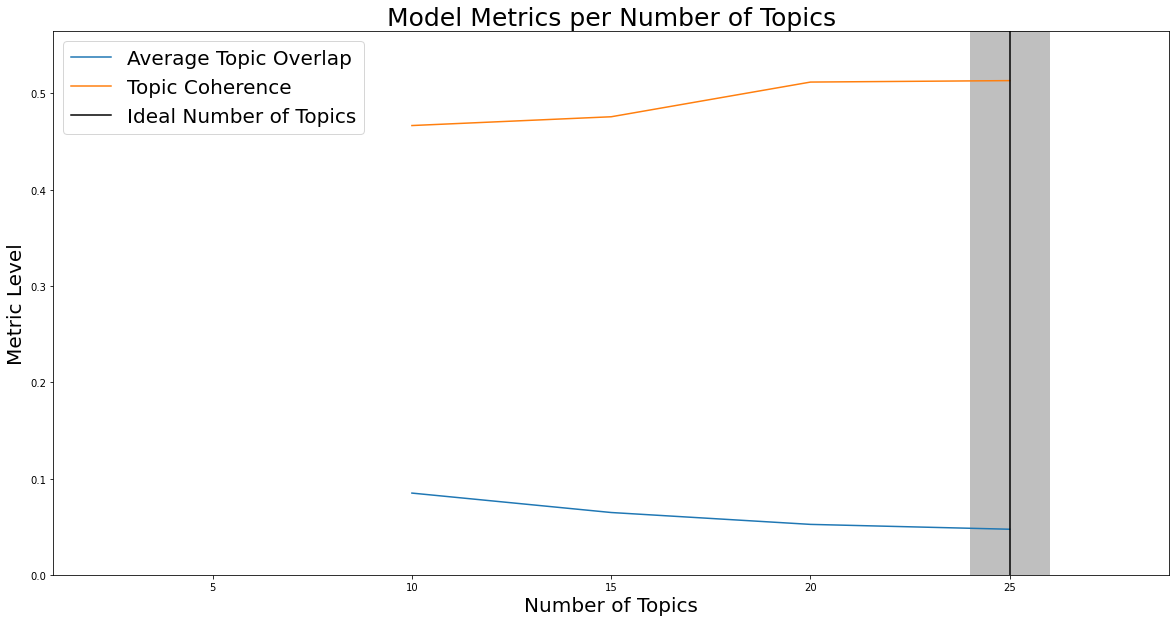

In [24]:
# graph these metrics across the topic numbers:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [25]:
LDA_models

{10: <gensim.models.ldamulticore.LdaMulticore at 0x7fe18097a1f0>,
 15: <gensim.models.ldamulticore.LdaMulticore at 0x7fe1809aff40>,
 20: <gensim.models.ldamulticore.LdaMulticore at 0x7fe1809a8f70>,
 25: <gensim.models.ldamulticore.LdaMulticore at 0x7fe179321f70>,
 30: <gensim.models.ldamulticore.LdaMulticore at 0x7fe17435df70>}

# Do hyperparamter tunings
## Now we know the optimal range of number of topics, let's tune alpha and beta

In [26]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token_words_trigrams_lemm, 
                                         dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [31]:
# the latest!!!
import tqdm

grid = {}
grid['Validation_Set'] = {}
# Topics range 
min_topics = 20
max_topics = 25
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
'''
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(loaded_corp, num_of_docs*0.75), 
               loaded_corp]
corpus_title = ['75% Corpus', '100% Corpus']
'''
corpus_sets = [corpus]
corpus_title = ['100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  1%|▎                                      | 4/540 [11:19<25:17:24, 169.86s/it]

  0%|▏                                      | 2/540 [03:44<16:43:26, 111.91s/it]/Users/djoko/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamodel.py:1133: RuntimeWarning: invalid value encountered in multiply
  score += np.sum((self.eta - _lambda) * Elogbeta)
/Users/djoko/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamodel.py:1134: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(_lambda) - gammaln(self.eta))

  3%|█▏                                  | 18/540 [1:00:46<29:22:34, 202.59s/it]


In [32]:
pd.DataFrame(model_results)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,20,0.000,0.000,0.520
1,100% Corpus,20,0.000,symmetric,0.520
2,100% Corpus,20,symmetric,0.000,0.508
3,100% Corpus,20,symmetric,symmetric,0.497
4,100% Corpus,20,asymmetric,0.000,0.509
5,100% Corpus,20,asymmetric,symmetric,0.500
6,100% Corpus,22,0.000,0.000,0.520
7,100% Corpus,22,0.000,symmetric,0.520
8,100% Corpus,22,symmetric,0.000,0.515
9,100% Corpus,22,symmetric,symmetric,0.504


In [30]:
# start 5:59pm end 8:55pm
import tqdm

grid = {}
grid['Validation_Set'] = {}
# Topics range ------------------ update this!!
min_topics = 20
max_topics = 25
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
'''
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(loaded_corp, num_of_docs*0.75), 
               loaded_corp]
corpus_title = ['75% Corpus', '100% Corpus']
'''
corpus_sets = [corpus]
corpus_title = ['100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  1%|▎                                      | 4/540 [09:11<20:20:38, 136.64s/it]Process SpawnPoolWorker-345:
Process SpawnPoolWorker-334:
Process SpawnPoolWorker-338:
Process SpawnPoolWorker-333:
Process SpawnPoolWorker-332:
Process SpawnPoolWorker-336:
Process SpawnPoolWorker-342:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/djoko/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/djoko/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/djoko/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/Users/djoko/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_que

KeyboardInterrupt: 

In [78]:
pd.DataFrame(model_results)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,10,0.010,0.010,0.479
1,100% Corpus,10,0.010,symmetric,0.479
2,100% Corpus,10,symmetric,0.010,0.483
3,100% Corpus,10,symmetric,symmetric,0.480
4,100% Corpus,10,asymmetric,0.010,0.482
5,100% Corpus,10,asymmetric,symmetric,0.482
6,100% Corpus,20,0.010,0.010,0.488
7,100% Corpus,20,0.010,symmetric,0.499
8,100% Corpus,20,symmetric,0.010,0.497
9,100% Corpus,20,symmetric,symmetric,0.495


In [15]:
# auto will take longer, it will try to find the best values
# start at 9:33 - 9:50
lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.46546967998519284

In [33]:
################## rerun the latest!
# auto will take longer, it will try to find the best values

lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, ############
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='asymmetric',
                                           eta='symmetric')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.48736182749017803

In [34]:
################## rerun the latest!
# auto will take longer, it will try to find the best values

lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, ##########
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='asymmetric',
                                           eta='symmetric')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.5046890717540111

In [36]:
################## rerun the latest! USE THIS ONE!!
# auto will take longer, it will try to find the best values

lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, ##########
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='asymmetric',
                                           eta='symmetric')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.5046890717540111

In [35]:
################## rerun the latest!
# auto will take longer, it will try to find the best values

lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, ##########
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.4990266748148882

In [40]:
import pickle

#pickle.dump(bestModel, 'lda_models/lda_model_1.pk')
    # ----- get error
with open('sub_sample/lda_model_sample.May2.pk',"wb") as f:
    pickle.dump(lda_model_opt, f)
# then load it back
#bestModel = pickle.load('lda_models/lda_model.pk')

In [38]:
lda_model_opt.alpha

array([0.1064781 , 0.08873175, 0.07605579, 0.06654881, 0.0591545 ,
       0.05323905, 0.04839914, 0.04436588, 0.04095311, 0.03802789,
       0.0354927 , 0.0332744 , 0.03131709, 0.02957725, 0.02802055,
       0.02661952, 0.02535193, 0.02419957, 0.02314741, 0.02218294,
       0.02129562, 0.02047656, 0.01971817, 0.01901395, 0.01835829],
      dtype=float32)

In [86]:
# auto will take longer, it will try to find the best values

lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha=0.01,
                                           eta=0.01)
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.4936912784190697

In [85]:
# auto will take longer, it will try to find the best values
# start at 9:51
lda_model_opt = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto')
    
coherence_model_lda = CoherenceModel(model=lda_model_opt, texts=token_words_trigrams_lemm, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.4951999666817529